In [157]:
import os
import sys

cwd = os.getcwd()
pwd = cwd[:cwd.rfind('/')]
sys.path.append(pwd)

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from dataloader import DatasetTrainClean, DatasetClean

In [132]:
# Dataset
data_path = '../data/'
trn_dataset = DatasetTrainClean(data_path)
val_dataset = DatasetClean(data_path)
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=1, shuffle=False, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

labs = ['bckgrnd', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'constrn', 'plant', 'road', 'sky']
cmap = np.array([
        #  R,   G,   B
        (  0,   0,   0),  #  Background
        # (192, 128, 128),  #  Person
        (255, 127,  14),  #  Person
        (  0, 128,   0),  #  Bike
        # (128, 128, 128),  #  Car
        (152,  78, 163),  #  Car
        (128,   0,   0),  #  Drone
        (  0,   0, 128),  #  Boat
        (192,   0, 128),  #  Animal
        (192,   0,   0),  #  Obstacle
        (192, 128,   0),  #  Construction
        (  0,  64,   0),  #  Plant
        (128, 128,   0),  #  Road
        (  0, 128, 128)   #  Sky
    ])

In [135]:
frqn_ins = np.zeros((12), dtype=int)        # Frequency by instances
frqn_pxl = np.zeros((12), dtype=np.float64) # Frequency by pixels
frqn_pos = np.zeros((720, 1280, 12))        # Frequency in position

for batch_i, (x, y) in enumerate(tqdm(trn_dataloader)):
    y = torch.Tensor(y).long()
    frq = F.one_hot(y, num_classes=12)
    frq = torch.sum(frq, axis=0)
    for c in range(12):
        s = torch.sum(frq[:,:,c]).numpy()
        if s > 0:
            frqn_ins[c] += 1
            frqn_pxl[c] += s
    frqn_pos += frq.numpy()

2621it [03:59, 10.93it/s]


In [133]:
frqv_ins = np.zeros((12), dtype=int)
frqv_pxl = np.zeros((12), dtype=np.float64)
frqv_pos = np.zeros((720, 1280, 12)) 

for batch_i, (x, y) in enumerate(tqdm(val_dataloader)):
    y = torch.Tensor(y).long()
    frq = F.one_hot(y, num_classes=12)
    frq = torch.sum(frq, axis=0)
    for c in range(12):
        s = torch.sum(frq[:,:,c]).numpy()
        if s > 0:
            frqv_ins[c] += 1
            frqv_pxl[c] += s
    frqv_pos += frq.numpy()

648it [01:00, 10.73it/s]


In [136]:
rtn_ins = frqn_ins / len(trn_dataset)       # Ratio by instances on train
rtn_pxl = frqn_pxl / np.sum(frqn_pxl)       # Ratio by pixels on train
rtv_ins = frqv_ins / len(val_dataset)       # Ratio by instances on validation
rtv_pxl = frqv_pxl / np.sum(frqv_pxl)       # Ratio by pixels on validation
rt_pxl = (frqn_pxl + frqv_pxl) / np.sum(frqn_pxl + frqv_pxl)
frqv_ins

array([648, 374, 173, 243, 146,  17,  27, 418, 274, 569, 510, 132])

## Bar plot

In [145]:
issave = True

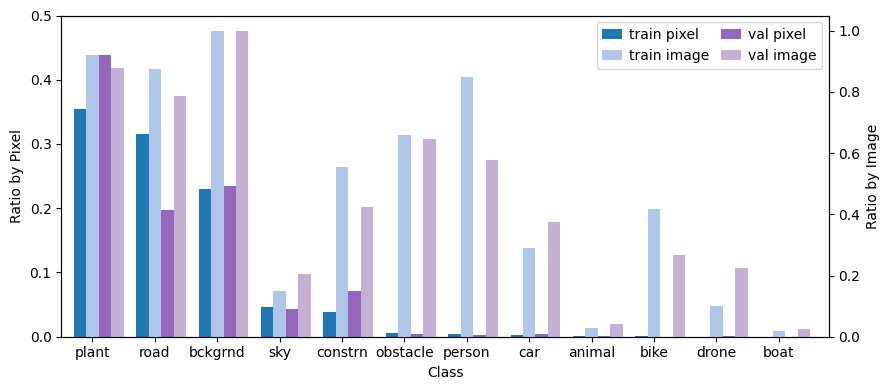

In [149]:
fig, ax_pxl = plt.subplots(figsize=(9, 4))
cm = plt.cm.tab20(np.arange(0, 20))
ax_ins = ax_pxl.twinx()

width = 0.2
# x = np.arange(len(labs))
# x = np.array([0., 6, 9, 7, 10, 11, 8, 5, 4, 1, 2, 3])
x = np.array([np.where(np.argsort(rt_pxl)[::-1] == i) for i in range(12)]).reshape(-1)
p1 = ax_pxl.bar(x-width,     rtn_pxl, width=width, color=cm[0], align='center', label='train pixel')
p2 = ax_ins.bar(x,           rtn_ins, width=width, color=cm[1], align='center', label='train image')
p3 = ax_pxl.bar(x+(width*1), rtv_pxl, width=width, color=cm[8], align='center', label='val pixel')
p4 = ax_ins.bar(x+(width*2), rtv_ins, width=width, color=cm[9], align='center', label='val image')

lst = [p1,p2,p3,p4]
ax_pxl.legend(handles=lst, ncol=2, loc=0,
            columnspacing=0.9, handlelength=1.4, handletextpad=0.5,)

ax_pxl.set_xticks(x, labs, fontsize=10)
ax_pxl.set_xlim([-0.5, 11.8])
ax_pxl.set(ylim=[0, 0.5], ylabel='Ratio by Pixel', xlabel='Class')
ax_ins.set(ylim=[0, 1.05], ylabel='Ratio by Image')

fig.tight_layout()
if issave:
    fig.savefig('./figs/2dist_sort.pdf', bbox_inches='tight')

## Avg Image

In [56]:
import imgviz

In [47]:
frq_pos = frqn_pos + frqv_pos
rtn_pos = frq_pos / (len(trn_dataset) + len(val_dataset))
img_avg = np.zeros((720, 1280, 3), dtype=np.float64) 

for c in range(12):
    img_avg += rtn_pos[:,:,c][:, :, None] * cmap[c]

In [42]:
frq_pos = frqn_pos + frqv_pos
frq_thg = frq_pos[:, :, 1:8]
rtn_thg = frq_thg / (len(trn_dataset) + len(val_dataset))
rtn_thg = rtn_thg / np.sum(rtn_thg, axis=2).max()
img_avg = np.zeros((720, 1280, 3), dtype=np.float64) 

for c in range(1, 8):
    img_avg += rtn_thg[:,:,c-1][:, :, None] * cmap[c]

In [159]:
frq_pos = frqn_pos + frqv_pos
# cm = plt.cm.Set1(np.arange(0, 20))

def hmap_class(lst):
    frq_thg = frq_pos[:, :, lst]
    rtn_thg = frq_thg / (len(trn_dataset) + len(val_dataset))
    return rtn_thg

def avgimg_class(lst):
    nclass = len(lst)
    frq_thg = frq_pos[:, :, lst]
    rtn_thg = frq_thg / (len(trn_dataset) + len(val_dataset))
    rtn_max = np.sum(rtn_thg, axis=2).max()
    rtn_thg = rtn_thg / rtn_max
    img_thg = np.zeros((720, 1280, 3), dtype=np.float64) 
    for c in range(nclass):
        img_thg += rtn_thg[:,:,c][:, :, None] * cmap[lst[c]]  
        # img_thg += rtn_thg[:,:,c][:, :, None] * cm[c][:3] * 255

    lab_thg = np.ones((720, 1280), dtype=int)
    lab_thg[0, :nclass] = lst
    return img_thg, lab_thg, rtn_max

(-0.5, 1279.5, 719.5, -0.5)

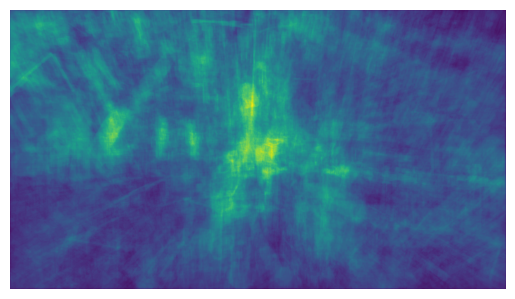

In [73]:
# lst = [i for i in range(1, 8)]
lst = [1, 3, 7]
rtn_thg = hmap_class(lst)
img_1 = np.sum(rtn_thg, axis=2)

# plt.figure(dpi=200)
plt.imshow(img_1, vmin=0, vmax=img_1.max())
plt.axis("off")

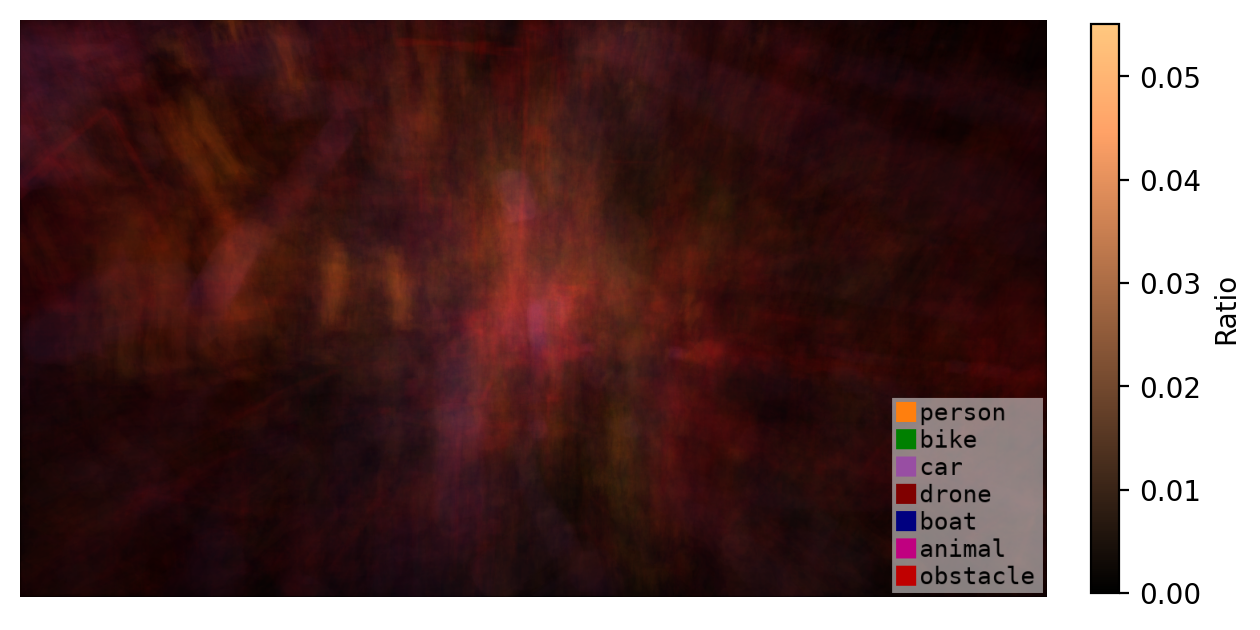

In [165]:
img_thg, lab_thg, rtn_max = avgimg_class(np.arange(1, 8))
labelviz = imgviz.label2rgb(
            label=lab_thg, image=img_thg.astype('uint8'), alpha=0.0,
            label_names=labs, colormap=cmap, font_size=30, loc="rb"
        )

bmap = mpl.cm.copper
norm = mpl.colors.Normalize(vmin=0, vmax=rtn_max)

fig, ax = plt.subplots(dpi=200)
img = plt.imshow(labelviz)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=bmap), 
             ax=ax, fraction=0.046*720/1280, pad=0.04, label='Ratio')
ax.axis("off")
fig.tight_layout()
if issave:
    fig.savefig('./figs/2avg_things.pdf', bbox_inches='tight')

(-0.5, 1279.5, 719.5, -0.5)

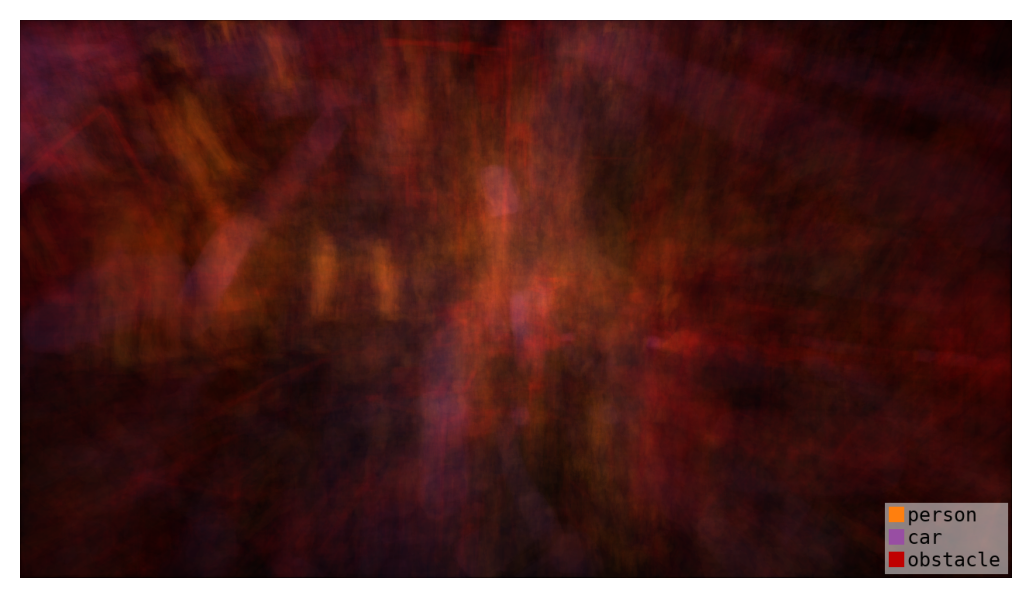

In [119]:
img_thg, lab_thg = avgimg_class([1, 3, 7])
labelviz = imgviz.label2rgb(
            label=lab_thg, image=img_thg.astype('uint8'), alpha=0.0,
            label_names=labs, colormap=cmap, font_size=25, loc="rb"
        )

plt.figure(dpi=200)
plt.imshow(labelviz)
plt.axis("off")